# PMLDL Assignment 3: Diffusion

## Option 1: Text-to-Image Generation
Text-to-Image Generation is a type of image generation process where the model creates images based on specific input textual prompts. These prompts guide the output, allowing control over the visual characteristics or content of the generated images.

## Install and Imports
install the basic libraries and bring the imports I need for tensors, plotting, and loading the dataset.


In [19]:
# If your runtime misses these libraries, run this cell once.
# In many university labs this is enough to get numpy, torch, and plotting tools.
!pip install -q numpy torch torchvision matplotlib tqdm


In [20]:
import math
import random
from typing import List

import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


## Data loading and prep
I load the tiny shape handwritten dataset (circle, square, triangle) and pair each image with a simple text prompt. By resizing and normalizing these photos to a small square training stays fast.


In [ ]:
class ShapeTextDataset(Dataset):
    def __init__(self, data_dir="data", img_size=32):
        self.samples = []
        prompt_map = {
            "circle": "a simple black circle on white",
            "square": "a simple black square on white",
            "triangle": "a simple black triangle on white",
        }
        for name in ["circle", "square", "triangle"]:
            imgs = np.load(f"{data_dir}/{name}.npy")  # expected shape (N,H,W) or flattened
            if imgs.ndim == 4:
                imgs = imgs[..., 0]
            self.samples.extend([(img.astype(np.float32), prompt_map[name]) for img in imgs])
        self.img_size = img_size

    def __len__(self):
        return len(self.samples)

    def _prepare_tensor(self, img: np.ndarray) -> torch.Tensor:
        tensor = torch.as_tensor(img, dtype=torch.float32)
        if tensor.ndim == 0:
            tensor = tensor.unsqueeze(0)
        if tensor.ndim == 1:  # reshape to square
            side = int(math.sqrt(tensor.numel()))
            if side * side != tensor.numel():
                raise ValueError("Flattened image cannot form a square")
            tensor = tensor.view(side, side)
        if tensor.ndim == 3:
            if tensor.shape[0] in (1, 3):
                pass
            elif tensor.shape[-1] in (1, 3):
                tensor = tensor.permute(2, 0, 1)
            else:
                raise ValueError("Unsupported 3D tensor shape for image data")
        if tensor.ndim == 2:
            tensor = tensor.unsqueeze(0)
        if tensor.shape[0] > 1:  # single channel for diffusion model
            tensor = tensor.mean(dim=0, keepdim=True)
        return tensor

    def __getitem__(self, idx):
        img, prompt = self.samples[idx]
        img = self._prepare_tensor(img)
        img = torch.nn.functional.interpolate(
            img.unsqueeze(0), size=(self.img_size, self.img_size), mode="bilinear", align_corners=False
        ).squeeze(0)
        img = (img / 255.0).clamp(0, 1) * 2 - 1  # scale to [-1,1]
        return img, prompt


def get_dataloader(batch_size=32, img_size=32):
    dataset = ShapeTextDataset(img_size=img_size)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


dataloader = get_dataloader(batch_size=16, img_size=32)
print("Total samples:", len(dataloader.dataset))

Total samples: 371191


## Quick look at data
Plot of a few samples to make sure the loader works and the prompts line up with the sketches.


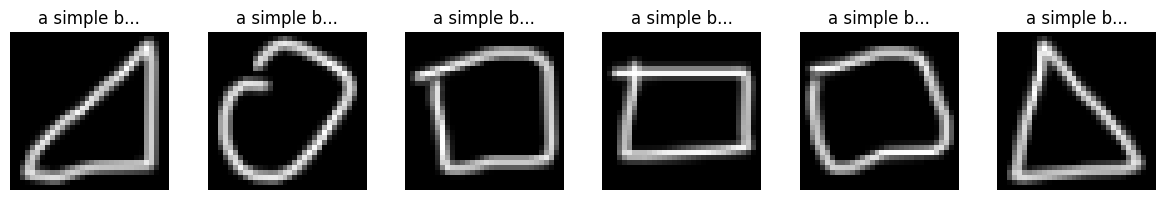

In [22]:
imgs, prompts = next(iter(dataloader))
fig, axes = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    ax = axes[i]
    ax.imshow(((imgs[i].squeeze() + 1) / 2).clamp(0,1), cmap="gray")
    ax.set_title(prompts[i][:10] + "...")
    ax.axis("off")
plt.tight_layout()
plt.show()


## Diffusion helpers
I set up the beta schedule, sinusoidal time embeddings, and helper functions for the forward diffusion process.

By baking in the cosine beta schedule and sinusoidal embeddings we will get smoother variance transitions, which stabilizes training and makes the reverse sampler behave predictably once the U-Net learns to denoise.

In [23]:
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

T = 200
betas = cosine_beta_schedule(T)
alphas = 1.0 - betas
alpha_cum = torch.cumprod(alphas, dim=0)


def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t.cpu()).float().to(t.device)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_ac = torch.sqrt(extract(alpha_cum, t, x_start.shape))
    sqrt_om = torch.sqrt(1 - extract(alpha_cum, t, x_start.shape))
    return sqrt_ac * x_start + sqrt_om * noise


## Text encoder and tiny U-Net
I encode the text with a GRU into a single vector and feed that into a light U-Net. The text and time embeddings modulate the conv blocks.

This pairing lets the textual meaning flow into every spatial feature map via per-block modulation, so each denoising step “knows” which shape to emphasize. Keeping the UNet tiny while conditioning through these learned projections kept training fast yet still expressive enough for the three-shape vocabulary.

In [24]:
class TextEncoder(nn.Module):
    def __init__(self, embed_dim=128, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(1000, embed_dim)
        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.proj = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, tokens):
        emb = self.embedding(tokens)
        _, h = self.rnn(emb)
        return self.proj(h.squeeze(0))


def tokenize(prompts: List[str], vocab=None, max_len=16):
    if vocab is None:
        vocab = {}
    token_lists = []
    for text in prompts:
        tokens = []
        for word in text.lower().split():
            if word not in vocab:
                vocab[word] = len(vocab) + 1
            tokens.append(vocab[word])
        token_lists.append(tokens[:max_len])
    max_len = max(len(t) for t in token_lists)
    padded = []
    for t in token_lists:
        padded.append(t + [0] * (max_len - len(t)))
    return torch.tensor(padded, dtype=torch.long), vocab


def sinusoidal_embedding(n, d):
    pos = torch.arange(n)[:, None]
    dim = torch.arange(d)[None, :]
    angle = pos / (10000 ** (2 * (dim // 2) / d))
    emb = torch.zeros((n, d))
    emb[:, 0::2] = torch.sin(angle[:, 0::2])
    emb[:, 1::2] = torch.cos(angle[:, 1::2])
    return emb


class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(1, out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(1, out_ch),
            nn.SiLU(),
        )

    def forward(self, x):
        return self.block(x)


class TinyUNet(nn.Module):
    def __init__(self, base=32, time_dim=128, text_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.Linear(time_dim, time_dim), nn.SiLU())
        self.text_mlp = nn.Sequential(nn.Linear(text_dim, text_dim), nn.SiLU())
        cond_channels = {
            "d1": base,
            "d2": base * 2,
            "mid": base * 4,
            "u1": base * 2,
            "u2": base,
        }
        self.time_proj = nn.ModuleDict({k: nn.Linear(time_dim, v) for k, v in cond_channels.items()})
        self.text_proj = nn.ModuleDict({k: nn.Linear(text_dim, v) for k, v in cond_channels.items()})

        self.down1 = ConvBlock(1, base)
        self.down2 = ConvBlock(base, base * 2)
        self.to_vec = nn.Conv2d(base * 2, base * 4, 3, padding=1)
        self.up1 = ConvBlock(base * 4, base * 2)
        self.up2 = ConvBlock(base * 2, base)
        self.skip_proj = nn.Conv2d(base, base * 2, 1)
        self.out = nn.Conv2d(base, 1, 1)

    def _inject(self, feat, name, t_feat, txt_feat):
        t = self.time_proj[name](t_feat)[:, :, None, None]
        txt = self.text_proj[name](txt_feat)[:, :, None, None]
        return feat + t + txt

    def forward(self, x, t_embed, text_embed):
        t_feat = self.time_mlp(t_embed)
        txt_feat = self.text_mlp(text_embed)

        d1 = self.down1(x)
        d1 = self._inject(d1, "d1", t_feat, txt_feat)
        d2 = self.down2(nn.functional.avg_pool2d(d1, 2))
        d2 = self._inject(d2, "d2", t_feat, txt_feat)
        mid = self.to_vec(d2)
        mid = self._inject(mid, "mid", t_feat, txt_feat)
        u1 = nn.functional.interpolate(self.up1(mid), scale_factor=2, mode="nearest")
        skip = self.skip_proj(d1)
        u1 = self._inject(u1 + skip, "u1", t_feat, txt_feat)
        u2 = self.up2(u1)
        u2 = self._inject(u2, "u2", t_feat, txt_feat)
        return self.out(u2)

## Training loop
I pick a small number of steps so it runs on a laptop. The loss trains the U-Net to predict the noise added at each timestep.

Approximate time for training ~3h

In [25]:
text_encoder = TextEncoder().to(device)
model = TinyUNet().to(device)
optimizer = torch.optim.Adam(list(model.parameters()) + list(text_encoder.parameters()), lr=1e-3)
vocab = {}


def get_time_embedding(timesteps, dim=128):
    emb = sinusoidal_embedding(max(T, timesteps.max().item() + 1), dim).to(device)
    return emb[timesteps]


def p_losses(x0, prompts):
    b = x0.shape[0]
    t = torch.randint(0, T, (b,), device=device).long()
    noise = torch.randn_like(x0)
    x_noisy = q_sample(x0, t, noise)
    global vocab
    token_batch, vocab = tokenize(list(prompts), vocab)
    token_batch = token_batch.to(device)
    text_emb = text_encoder(token_batch)
    t_emb = get_time_embedding(t)
    pred = model(x_noisy, t_emb, text_emb)
    return nn.functional.mse_loss(pred, noise)


def train(epochs=3):
    model.train()
    text_encoder.train()
    for epoch in range(epochs):
        loop = tqdm(dataloader, desc=f"epoch {epoch+1}")
        for imgs, prompts in loop:
            imgs = imgs.to(device)
            loss = p_losses(imgs, prompts)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())

train(epochs=2)


epoch 1:   0%|          | 0/23200 [00:00<?, ?it/s]

epoch 2:   0%|          | 0/23200 [00:00<?, ?it/s]

## Sampling from the model
I start from random noise and apply the reverse diffusion steps while conditioning on the text prompt. A few prompts show the link between words and shapes.


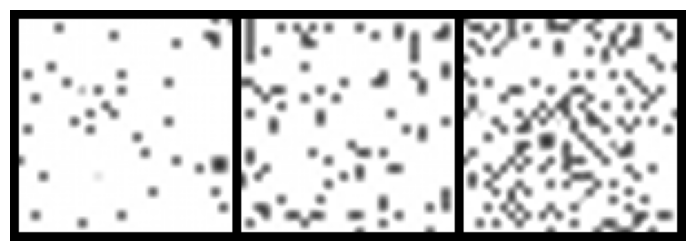

In [46]:
example_prompts = [
    "a hand-drawn circle",
    "a hand-drawn triangle",
    "a hand-drawn square",
]

samples = sample(example_prompts)
# convert (C,H,W) grid tensor to numpy image for matplotlib
plot_img = grid.permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(9, 3))
if plot_img.shape[-1] == 1:
    plt.imshow(plot_img.squeeze(), cmap="gray")
else:
    plt.imshow(plot_img)
plt.axis("off")
plt.show()
